# Dataset obtained from:

https://www.mammaldiversity.org/


# How to build the hierarchy or the knowledge graph?

## Extract only the major ranks from the dataset: (Common Name, species, genus, family, order, subclass)

In [ ]:
import pandas as pd

df = pd.read_csv("/content/species.csv")

# columns to keep
keep = [
    "mainCommonName",
    "sciName",
    "genus",
    "family",
    "order",
    "subclass"
]

# rename columns
df_small = (
    df[keep]
      .drop_duplicates()
      .reset_index(drop=True)
      .rename(columns={
          "mainCommonName": "CommonName",
          "sciName": "Species",
          "genus": "Genus",
          "family": "Family",
          "order": "Order",
          "subclass": "Subclass",
      })
)

# save
df_small.to_csv("/content/mammal_major_ranks.csv", index=False)


In [ ]:
print(df_small)

                              CommonName                   Species  \
0                               Platypus  Ornithorhynchus_anatinus   
1                   Short-beaked Echidna    Tachyglossus_aculeatus   
2     Attenborough's Long-beaked Echidna   Zaglossus_attenboroughi   
3            Eastern Long-beaked Echidna         Zaglossus_bartoni   
4            Western Long-beaked Echidna        Zaglossus_bruijnii   
...                                  ...                       ...   
6796                  Pygmy Beaked Whale     Mesoplodon_peruvianus   
6797            Stejneger's Beaked Whale     Mesoplodon_stejnegeri   
6798                 Spade-toothed Whale      Mesoplodon_traversii   
6799             Shepherd's Beaked Whale      Tasmacetus_shepherdi   
6800               Cuvier's Beaked Whale       Ziphius_cavirostris   

                Genus             Family         Order    Subclass  
0     Ornithorhynchus  Ornithorhynchidae   Monotremata  Yinotheria  
1        Tachyglossus

In [ ]:
# number of unique Species
df_small["Species"].nunique()

6801

In [ ]:
# number of unique Genus
df_small["Genus"].nunique()

1357

In [ ]:
# number of unique Family
df_small["Family"].nunique()

167

In [ ]:
# number of unique Orders
df_small["Order"].nunique()

27

In [ ]:
# number of unique Subclasses
df_small["Subclass"].nunique()

2

In [ ]:
# Print unique Subclasses
counts = df_small["Subclass"].value_counts(dropna=False)
print(counts)

Subclass
Theria        6796
Yinotheria       5
Name: count, dtype: int64


## Generate Embeddings (OpenAI text-embedding-3-large) - (embed species + commonName)

In [ ]:
import os, numpy as np
from tqdm import tqdm
from openai import OpenAI

In [ ]:
client = OpenAI(api_key="")

def get_openai_embeddings(texts, model="text-embedding-3-large", batch_size=96):
    all_embeds = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding"):
        batch = texts[i : i + batch_size]

        response = client.embeddings.create(
            model=model,
            input=batch,
            encoding_format="float"
        )

        batch_sorted = sorted(response.data, key=lambda o: o.index)
        all_embeds.extend([item.embedding for item in batch_sorted])

    return np.asarray(all_embeds, dtype=np.float32)


In [ ]:
# embed species + commonName
df_small["text_for_embed"] = (
    df_small["Species"].str.replace("_", " ")
    + " | "
    + df_small["CommonName"]
)

texts = df_small["text_for_embed"].tolist()
emb   = get_openai_embeddings(texts)

print(emb.shape, emb.dtype)

Embedding: 100%|██████████| 71/71 [03:56<00:00,  3.33s/it]

(6801, 3072) float32


#KMeans (K=27 : number of unique Orders)

In [ ]:
pip install kneed

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

km_final  = KMeans(n_clusters=27, n_init=30, random_state=42)
labels    = km_final.fit_predict(emb)
centroids = km_final.cluster_centers_


# Method from [LLMEdgeRefine: Enhancing Text Clustering with LLM-Based Boundary Point Refinement](https://aclanthology.org/2024.emnlp-main.1025/)

## SPEC: "Super-point Enhanced Clustering"
1) **Extract the farthest α% (e.g., 10%) from each cluster:** For each cluster, compute Euclidean distance between all points and their cluster centroid. Select the top α% farthest points (these are considered edge points or potential outliers).

2) **Form a super-point from each set of edge points:** For each cluster, average the embeddings of the selected edge points to form a single super-point vector. This acts as a dense representation of the "tail" of the cluster and reduces the influence of noise.

3) **Treat remaining (non-edge) points as singleton clusters**: Each non-super-point stays individually represented. So the new dataset consists of:
- One super-point per cluster
- All remaining points as singletons

4) **Run agglomerative clustering on this mixed set:** Use AgglomerativeClustering(linkage="average", n_clusters=K) to cluster the combined set of singleton points and super-points. Fix cardinality.
- Super-points act like anchors to steer cluster shapes.

5) **Assign new labels to all original points**: Every original point (including those used to create super-points) is assigned a new cluster label based on its closest new cluster (e.g., via nearest centroid or label propagation).


6) **Recompute centroids for each cluster**: Update the cluster centroids based on the newly assigned labels. These centroids will be used in the next iteration (if repeating SPEC).

In [ ]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering

def spec_step(X, labels, centroids, alpha=.10):
    N = X.shape[0]
    super_points, super_idx = [], []
    remain_idx = []

    # 1) build super-points per cluster
    for c in np.unique(labels):
        idx = np.where(labels == c)[0]
        dists = np.linalg.norm(X[idx] - centroids[c], axis=1)
        take = int(max(1, np.ceil(alpha * len(idx))))
        far_idx = idx[np.argsort(dists)[-take:]]
        # centroid of farthest points: super point
        super_points.append(X[far_idx].mean(0))
        super_idx.extend(far_idx)
        remain_idx.extend(np.setdiff1d(idx, far_idx))

    # 2) make the dataset for agglomerative clustering
    X_new   = np.vstack([X[remain_idx], np.vstack(super_points)])
    #   first remain_idx rows are singletons, rest are super points
    n_clusters = len(set(labels))
    ac = AgglomerativeClustering(n_clusters=n_clusters, linkage="average")
    new_labels = ac.fit_predict(X_new)

    # 3) map back to original order
    final = np.empty(N, dtype=int)

    # a) singletons
    final[remain_idx] = new_labels[:len(remain_idx)]

    # b) far points look up by cluster
    offset = len(remain_idx)
    for j, c in enumerate(np.unique(labels)):
        lab_for_super = new_labels[offset + j]
        idx = np.where(labels == c)[0]
        dists = np.linalg.norm(X[idx] - centroids[c], axis=1)
        take = int(max(1, np.ceil(alpha * len(idx))))
        far_idx = idx[np.argsort(dists)[-take:]]
        final[far_idx] = lab_for_super


    # 4) recompute centroids
    cents = np.vstack([X[final == k].mean(0) for k in range(n_clusters)])
    return final, cents


In [ ]:
for _ in range(5):
    labels, centroids = spec_step(emb, labels, centroids, alpha=.10)


## LACR (LLM-Assisted Cluster Refinement) Using GPT-4.1:
1) For each cluster, extract the farthest β% (10%) of points from the centroid (based on Euclidean distance). These are considered edge points likely to be noisy or semantically misplaced.

2) For the farthest points, rank all centroids by cosine similarity and pick the top 8 closest clusters. Candidate descriptions for each cluster contains "Species: X, Common Name: Y" for Max 20 animals closest to the center of the cluster

3) Query LLM if each of the farthest points should stay in that cluster or reassigned to one of the top 8 closest clusters. If LLM outputs outputs "keep", label is unchanged. If LLM outputs a number, reassign to that cluster.

4) Recompute centroids based on updated labels

In [ ]:
from openai import OpenAI

client = OpenAI(api_key="")

# return True if LLM says 'keep', False if 'move'.
def llm_keep(label_to_desc, point_text, prompt_tmpl):
  prompt = prompt_tmpl.format(point=point_text, **label_to_desc)

  resp = client.chat.completions.create(
      model="gpt-4.1",
      messages=[{"role": "user", "content": prompt}],
      temperature=0
  )
  reply = resp.choices[0].message.content.strip().upper()

  if reply == "KEEP":
      return True

  try:
      return int(reply)
  except ValueError:
      return True


prompt_template = """
You are refining clusters of animal names.
{point}

Below are 8 candidate cluster descriptions:

1. {c1}
2. {c2}
3. {c3}
4. {c4}
5. {c5}
6. {c6}
7. {c7}
8. {c8}

Choose the ONE cluster index that fits best, or say KEEP if it already fits.
Respond with just the number 1-8, or 'KEEP'.
"""
beta = 0.10
l = 3

for _ in range(l):
    move_these = []  # <<<<<< ADD THIS: fresh start every loop

    # 1) pick 10% farthest names per cluster
    unique_labels = np.unique(labels)

    centroids = np.vstack([emb[labels == k].mean(0) for k in unique_labels])

    label_to_centroid_idx = {label: i for i, label in enumerate(unique_labels)}

    for k in unique_labels:
        idx = np.where(labels == k)[0]
        d = np.linalg.norm(emb[idx] - centroids[label_to_centroid_idx[k]], axis=1)
        take = min(len(idx), int(max(1, np.ceil(beta * len(idx)))))
        move_these.extend(idx[np.argsort(d)[-take:]])

    # 2) for every candidate point, build 8-nearest cluster list
    for idx in move_these:
        # cosine similarity to each centroid
        sims = (emb[idx] @ centroids.T) / (
            np.linalg.norm(emb[idx]) * np.linalg.norm(centroids, axis=1)
        )
        top8 = sims.argsort()[-8:][::-1]

        # cluster description: max 50 animals per cluster, with Species + CommonName
        desc = {}
        for i, c in enumerate(top8):
            cluster_idx = np.where(labels == c)[0]

            # Compute distance to centroid
            dists = np.linalg.norm(emb[cluster_idx] - centroids[label_to_centroid_idx[c]], axis=1)

            # Take 50 closest
            closest_idx = cluster_idx[np.argsort(dists)[:20]]

            subset = df_small.iloc[closest_idx][["Species", "CommonName"]]

            names = [f"Species: {row['Species']}, Common Name: {row['CommonName']}"
                     for _, row in subset.iterrows()]
            desc[f"c{i+1}"] = "\n".join(names)

        keep = llm_keep(desc, df_small.loc[idx, "text_for_embed"], prompt_template)
        if keep != True:
            new_label = top8[int(keep) - 1]
            labels[idx] = new_label

    # 3) after moves, recompute centroids
    centroids = np.vstack([emb[labels == k].mean(0) for k in np.unique(labels)])


# Evaluate and Inspect

In [ ]:
from sklearn.metrics import silhouette_score
sil = silhouette_score(emb, labels)
print(f"Silhouette = {sil:.3f}")

df_small["cluster"] = labels


Silhouette = 0.017


### Print Common Name, Order per each cluster

In [ ]:
# Make sure rows inside a cluster are ordered predictably
tmp = df_small.sort_values(["cluster", "Species"])

# How many examples per cluster?
n = 5

for c in sorted(tmp["cluster"].unique()):      # 0, 1, 2, …
    print(f"\n— Cluster {c} —")                # header line
    block = tmp[tmp["cluster"] == c].head(n)   # first n rows of this cluster
    print(block[["CommonName", "Order"]])    # choose columns to display


— Cluster 0 —
                       CommonName     Order
3646      Luzon Broad-toothed Rat  Rodentia
3264  Papuan Highland Brush Mouse  Rodentia
2600         Ruschi's Spiny Mouse  Rodentia
1325     Bennett's Chinchilla Rat  Rodentia
1326      Bolivian Chinchilla Rat  Rodentia

— Cluster 1 —
                    CommonName      Order
6278                   Cheetah  Carnivora
6399  Small-toothed Palm Civet  Carnivora
6182    Western Lowland Olingo  Carnivora
6279        African Golden Cat  Carnivora
6280                   Caracal  Carnivora

— Cluster 2 —
                         CommonName       Order
6237                Short-eared Dog   Carnivora
6336                 Marsh Mongoose   Carnivora
5403  White-striped Free-tailed Bat  Chiroptera
6183                      Olinguito   Carnivora
6184                       Ringtail   Carnivora

— Cluster 3 —
                    CommonName       Order
1537           Mountain Beaver    Rodentia
1096           Riverine Rabbit  Lagomorpha
1097   

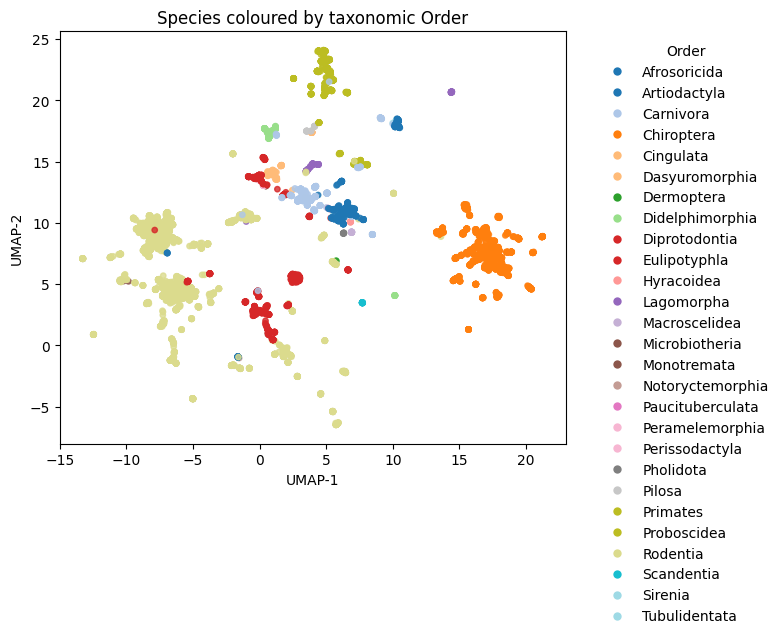

In [ ]:
import umap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines

orders = df_small["Order"].fillna("Unknown")
order_codes = orders.astype("category").cat.codes     # integers 0…M-1
unique_orders = orders.astype("category").cat.categories

# Build a categorical colormap with enough distinct hues
cmap = mpl.colors.ListedColormap(
    mpl.cm.tab20(np.linspace(0, 1, len(unique_orders)))
)

fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(u[:, 0], u[:, 1],
                c=order_codes,
                cmap=cmap,
                s=15, alpha=.8)

# Legend handles: use mlines.Line2D
handles = [
    mlines.Line2D([0], [0], marker='o', linestyle='',
                  markerfacecolor=cmap(i), markersize=6,
                  markeredgewidth=0, label=ordr)
    for i, ordr in enumerate(unique_orders)
]

ax.legend(handles=handles,
          bbox_to_anchor=(1.05, 1), loc='upper left',
          title="Order", frameon=False)
ax.set_title("Species coloured by taxonomic Order")
ax.set_xlabel("UMAP-1"); ax.set_ylabel("UMAP-2")
plt.tight_layout(); plt.show()


## Print unique orders per cluster with counts

In [ ]:
# Make sure rows are sorted predictably
tmp = df_small.sort_values(["cluster", "Species"])

# Print unique orders per cluster with counts
for c in sorted(tmp["cluster"].unique()):
    print(f"\n— Cluster {c} —")
    counts = tmp[tmp["cluster"] == c]["Order"].value_counts()
    for order, count in counts.items():
        print(f"{order}: {count}")



— Cluster 0 —
Rodentia: 2611
Eulipotyphla: 554
Diprotodontia: 126
Didelphimorphia: 120
Dasyuromorphia: 81
Chiroptera: 80
Afrosoricida: 50
Artiodactyla: 49
Primates: 32
Peramelemorphia: 31
Carnivora: 30
Cingulata: 23
Lagomorpha: 10
Pilosa: 9
Paucituberculata: 7
Scandentia: 5
Monotremata: 4
Perissodactyla: 4
Notoryctemorphia: 2
Microbiotheria: 2
Hyracoidea: 1
Macroscelidea: 1

— Cluster 1 —
Carnivora: 85
Primates: 17
Pholidota: 9

— Cluster 2 —
Carnivora: 81
Chiroptera: 38
Rodentia: 2
Diprotodontia: 1
Dasyuromorphia: 1

— Cluster 3 —
Lagomorpha: 102
Rodentia: 31
Diprotodontia: 17

— Cluster 4 —
Artiodactyla: 94
Carnivora: 1
Sirenia: 1

— Cluster 5 —
Artiodactyla: 183
Perissodactyla: 5
Primates: 1

— Cluster 6 —
Artiodactyla: 30
Perissodactyla: 9
Tubulidentata: 1

— Cluster 7 —
Chiroptera: 1218
Cingulata: 1

— Cluster 8 —
Dasyuromorphia: 8
Didelphimorphia: 6

— Cluster 9 —
Carnivora: 11
Pilosa: 8
Primates: 8

— Cluster 10 —
Carnivora: 35
Sirenia: 4

— Cluster 11 —
Primates: 416
Scandenti

# Calculate Mean Cluster Purity by Order

In [ ]:
import numpy as np

def mean_purity_from_labels(labels, orders):
    purities = []
    for k in np.unique(labels):
        idx     = np.where(labels == k)[0]
        ords    = orders.iloc[idx]
        top     = ords.value_counts().iloc[0]
        purities.append(top / len(ords))
    return np.mean(purities)

orders = df_small["Order"]
print("Mean cluster purity by Order:", mean_purity_from_labels(labels, orders))


Mean cluster purity by Order: 0.7973686432578847
